<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## LSTM Bot QA

### Datos
El objecto es utilizar datos disponibles del challenge ConvAI2 (Conversational Intelligence Challenge 2) de conversaciones en inglés. Se construirá un BOT para responder a preguntas del usuario (QA).\
[LINK](http://convai.io/data/)

In [3]:
MAX_VOCAB_SIZE = 8000
MAX_LENGTH = 10
N_UNITS = 128
EPOCHS = 40
LSTM_DROPOUT = 0.2

In [4]:
!pip install --upgrade --no-cache-dir gdown --quiet
!pip install --upgrade tensorflow


In [5]:
import re

import numpy as np
import pandas as pd

import tensorflow as tf
from keras.preprocessing.text import one_hot
from tensorflow.keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM, SimpleRNN
from keras.models import Model
from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.utils import plot_model
from keras.utils import to_categorical

In [6]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('data_volunteers.json', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download'
    output = 'data_volunteers.json'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [7]:
# dataset_file
import json

text_file = "data_volunteers.json"
with open(text_file) as f:
    data = json.load(f) # la variable data será un diccionario



In [8]:
# Observar los campos disponibles en cada linea del dataset
data[0].keys()

dict_keys(['dialog', 'start_time', 'end_time', 'bot_profile', 'user_profile', 'eval_score', 'profile_match', 'participant1_id', 'participant2_id'])

In [9]:
chat_in = []
chat_out = []

input_sentences = []
output_sentences = []
output_sentences_inputs = []
max_len = 30

def clean_text(txt):
    txt = txt.lower()
    txt.replace("\'d", " had")
    txt.replace("\'s", " is")
    txt.replace("\'m", " am")
    txt.replace("don't", "do not")
    txt = re.sub(r'\W+', ' ', txt)

    return txt

for line in data:
    for i in range(len(line['dialog'])-1):
        # vamos separando el texto en "preguntas" (chat_in)
        # y "respuestas" (chat_out)
        chat_in = clean_text(line['dialog'][i]['text'])
        chat_out = clean_text(line['dialog'][i+1]['text'])

        if len(chat_in) >= max_len or len(chat_out) >= max_len:
            continue

        input_sentence, output = chat_in, chat_out

        # output sentence (decoder_output) tiene <eos>
        output_sentence = output + ' <eos>'
        # output sentence input (decoder_input) tiene <sos>
        output_sentence_input = '<sos> ' + output

        input_sentences.append(input_sentence)
        output_sentences.append(output_sentence)
        output_sentences_inputs.append(output_sentence_input)

print("Cantidad de rows utilizadas:", len(input_sentences))

Cantidad de rows utilizadas: 6033


In [10]:
input_sentences[1], output_sentences[1], output_sentences_inputs[1]

('hi how are you ', 'not bad and you  <eos>', '<sos> not bad and you ')

### 2 - Preprocesamiento
Realizar el preprocesamiento necesario para obtener:
- word2idx_inputs, max_input_len
- word2idx_outputs, max_out_len, num_words_output
- encoder_input_sequences, decoder_output_sequences, decoder_targets

In [11]:
input_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

word2idx_inputs = input_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_inputs))

max_input_len = max(len(sen) for sen in input_integer_seq)
print("Sentencia de entrada más larga:", max_input_len)



Palabras en el vocabulario: 1799
Sentencia de entrada más larga: 9


In [12]:
output_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='!"#$%&()*+,-./:;=¿?@[\]^_`{|}~\t\n')
output_tokenizer.fit_on_texts(["", ""] + output_sentences)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

word2idx_outputs = output_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_outputs))

num_words_output = min(len(word2idx_outputs) + 1, MAX_VOCAB_SIZE) # Se suma 1 por el primer
print("Palabras de salida:", num_words_output)

max_out_len = max(len(sen) for sen in output_integer_seq)
print("Sentencia de salida más larga:", max_out_len)

Palabras en el vocabulario: 1805
Palabras de salida: 1806
Sentencia de salida más larga: 10


In [13]:
from keras.utils import to_categorical

In [14]:
encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences shape:", encoder_input_sequences.shape)

decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_sequences shape:", decoder_input_sequences.shape)

decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_output_sequences shape:", decoder_output_sequences.shape)

decoder_targets = to_categorical(decoder_output_sequences, num_classes=num_words_output)
print("decoder_targets shape:", decoder_targets.shape)

encoder_input_sequences shape: (6033, 9)
decoder_input_sequences shape: (6033, 10)
decoder_output_sequences shape: (6033, 10)
decoder_targets shape: (6033, 10, 1806)


### 3 - Preparar los embeddings
Utilizar los embeddings de Glove o FastText para transformar los tokens de entrada en vectores

In [15]:
if os.access('fasttext.pkl', os.F_OK) is False:
    url = 'https://drive.google.com/u/0/uc?id=1Qi1r-u5lsEsNqRSxLrpNOqQ3B_ufltCa&export=download&confirm=t'
    output = 'fasttext.pkl'
    gdown.download(url, output, quiet=False)
else:
    print("Los embeddings de fasttext ya están descargados.")


Los embeddings de fasttext ya están descargados.


In [16]:

import logging
import os
from pathlib import Path
from io import StringIO
import pickle

class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings

class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [17]:
model_embeddings = FasttextEmbeddings()

print('preparing embedding matrix...')
embed_dim = model_embeddings.N_FEATURES
words_not_found = []

# word_index provieen del tokenizer

nb_words = min(MAX_VOCAB_SIZE, len(word2idx_inputs)) # vocab_size
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word2idx_inputs.items():
    if i >= nb_words:
        continue
    embedding_vector = model_embeddings.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:

        embedding_matrix[i] = embedding_vector
    else:
        # words not found in embedding index will be all-zeros.
        words_not_found.append(word)

print('number of null word embeddings:', np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 1


In [18]:
# Dimensión de los embeddings de la secuencia en ingles
embedding_matrix.shape

(1799, 300)

### 4 - Entrenar el modelo
Entrenar un modelo basado en el esquema encoder-decoder utilizando los datos generados en los puntos anteriores. Utilce como referencias los ejemplos vistos en clase.

In [19]:
# define training encoder
encoder_inputs = Input(shape=(max_input_len))

encoder_embedding_layer = Embedding(
    input_dim=nb_words,
    output_dim=embed_dim,
    input_length=max_input_len,
    weights=[embedding_matrix],
    trainable=False)

encoder_inputs_x = encoder_embedding_layer(encoder_inputs)

encoder = LSTM(N_UNITS,
               return_state=True,
               dropout=LSTM_DROPOUT,
               )

encoder_outputs, state_h, state_c = encoder(encoder_inputs_x)
encoder_states = [state_h, state_c]

# define training decoder
decoder_inputs = Input(shape=(max_out_len))
decoder_embedding_layer = Embedding(
    input_dim=num_words_output,
    output_dim=N_UNITS,
    input_length=max_out_len)
decoder_inputs_x = decoder_embedding_layer(decoder_inputs)

decoder_lstm = LSTM(N_UNITS,
                    return_sequences=True,
                    return_state=True,
                    dropout=LSTM_DROPOUT,
                    )
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

# Dense
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(loss='categorical_crossentropy', optimizer="Adam", metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 9)]                  0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 10)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 9, 300)               539700    ['input_1[0][0]']             
                                                                                                  
 embedding_1 (Embedding)     (None, 10, 128)              231168    ['input_2[0][0]']             
                                                                                              

In [20]:
encoder_model = Model(encoder_inputs, encoder_states)

In [21]:
decoder_state_input_h = Input(shape=(N_UNITS,))
decoder_state_input_c = Input(shape=(N_UNITS,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding_layer(decoder_inputs_single)

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs_single] + decoder_states_inputs, [decoder_outputs] + decoder_states)


In [22]:
hist = model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets,
    epochs=EPOCHS,
    validation_split=0.2,
    )

Epoch 1/40
151/151 [==============================] - 15s 43ms/step - loss: 3.0677 - accuracy: 0.5090 - val_loss: 2.1965 - val_accuracy: 0.6410
Epoch 2/40
151/151 [==============================] - 2s 14ms/step - loss: 1.8199 - accuracy: 0.6804 - val_loss: 1.6849 - val_accuracy: 0.7181
Epoch 3/40
151/151 [==============================] - 2s 12ms/step - loss: 1.3397 - accuracy: 0.7752 - val_loss: 1.3417 - val_accuracy: 0.7936
Epoch 4/40
151/151 [==============================] - 2s 10ms/step - loss: 1.0374 - accuracy: 0.8280 - val_loss: 1.1243 - val_accuracy: 0.8355
Epoch 5/40
151/151 [==============================] - 2s 14ms/step - loss: 0.8427 - accuracy: 0.8690 - val_loss: 0.9757 - val_accuracy: 0.8664
Epoch 6/40
151/151 [==============================] - 2s 15ms/step - loss: 0.7055 - accuracy: 0.8942 - val_loss: 0.8672 - val_accuracy: 0.8858
Epoch 7/40
151/151 [==============================] - 2s 15ms/step - loss: 0.6061 - accuracy: 0.9116 - val_loss: 0.7912 - val_accuracy: 0.896

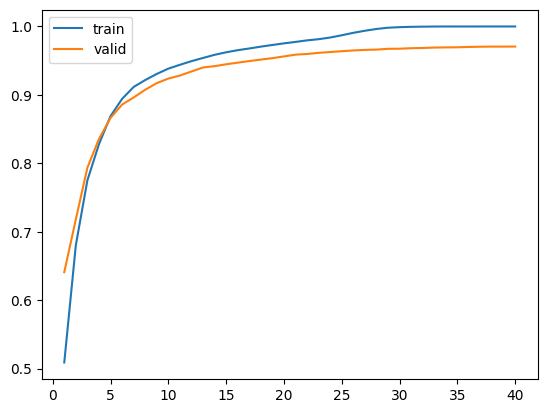

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()


### 5 - Inferencia
Experimentar el funcionamiento de su modelo. Recuerde que debe realizar la inferencia de los modelos por separado de encoder y decoder.

In [24]:
# Armar lo conversores de indice a palabra:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [31]:
def answer_prompt(input_seq):
    # Obtener los estados internos del modelo del codificador
    states_value = encoder_model.predict(input_seq)

    # Inicializar la secuencia de destino con un token vacío
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['']

    # Obtener el índice del token de final de oración
    eos = word2idx_outputs['']

    # Inicializar una lista para almacenar la traducción de salida
    output_sentence = []

    # Generar la secuencia de salida
    for _ in range(max_out_len):
        # Predecir los tokens de salida y los estados internos del modelo del decodificador
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Encontrar el índice del token con la probabilidad más alta
        idx = np.argmax(output_tokens[0, 0, :])

        # Comprobar si el token predicho es un token de final de oración
        if eos == idx:
            break

        word = ''
        if idx > 0:
            # Obtener la palabra correspondiente al índice predicho
            word = idx2word_target[idx]
            # Agregar la palabra a la traducción de salida
            output_sentence.append(word)

        # Actualizar los estados internos para la siguiente iteración
        states_value = [h, c]
        # Establecer el token predicho como entrada para la siguiente iteración
        target_seq[0, 0] = idx

    # Devolver la traducción de salida como una cadena
    return ' '.join(output_sentence)


In [32]:
input_test = "Do you read?"
print('Input:', input_test)
integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
print("Representacion en vector de tokens de ids", integer_seq_test)
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
print("Padding del vector:", encoder_sequence_test)

print('Input:', input_test)
translation = answer_prompt(encoder_sequence_test)
print('Response:', translation)

Input: Do you read?
Representacion en vector de tokens de ids [3, 2, 23]
Padding del vector: [[ 0  0  0  0  0  0  3  2 23]]
Input: Do you read?
1/1 [==============================] - 0s 27ms/step


KeyError: ignored

In [27]:
input_test = 'Do you have any pet?'
print('Input:', input_test)
integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
print("Representacion en vector de tokens de ids", integer_seq_test)
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
print("Padding del vector:", encoder_sequence_test)

print('Input:', input_test)
translation = answer_prompt(encoder_sequence_test)
print('Response:', translation)

Input: Do you have any pet?
Representacion en vector de tokens de ids [3, 2, 16, 31, 252]
Padding del vector: [[  0   0   0   0   3   2  16  31 252]]
Input: Do you have any pet?
1/1 [==============================] - 0s 18ms/step


KeyError: ignored

In [28]:

input_test = 'Where are you from?'
print('Input:', input_test)
integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
print("Representacion en vector de tokens de ids", integer_seq_test)
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
print("Padding del vector:", encoder_sequence_test)

print('Input:', input_test)
translation = answer_prompt(encoder_sequence_test)
print('Response:', translation)

Input: Where are you from?
Representacion en vector de tokens de ids [52, 7, 2, 39]
Padding del vector: [[ 0  0  0  0  0 52  7  2 39]]
Input: Where are you from?
1/1 [==============================] - 0s 17ms/step


KeyError: ignored